Length of anomaly: 144
Length of co2: 144
Pearson correlation coefficient: 0.93
P-value: 5.22e-65


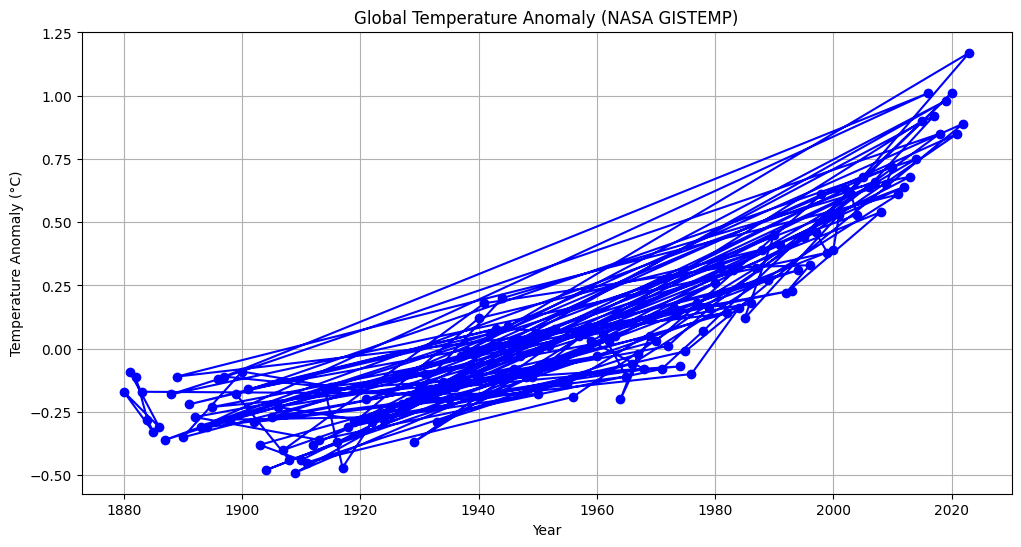

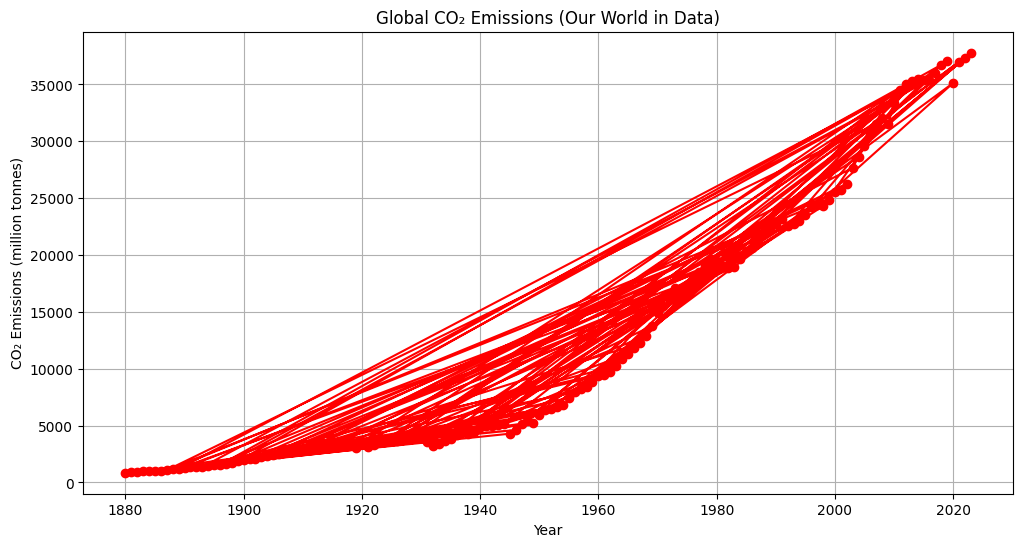

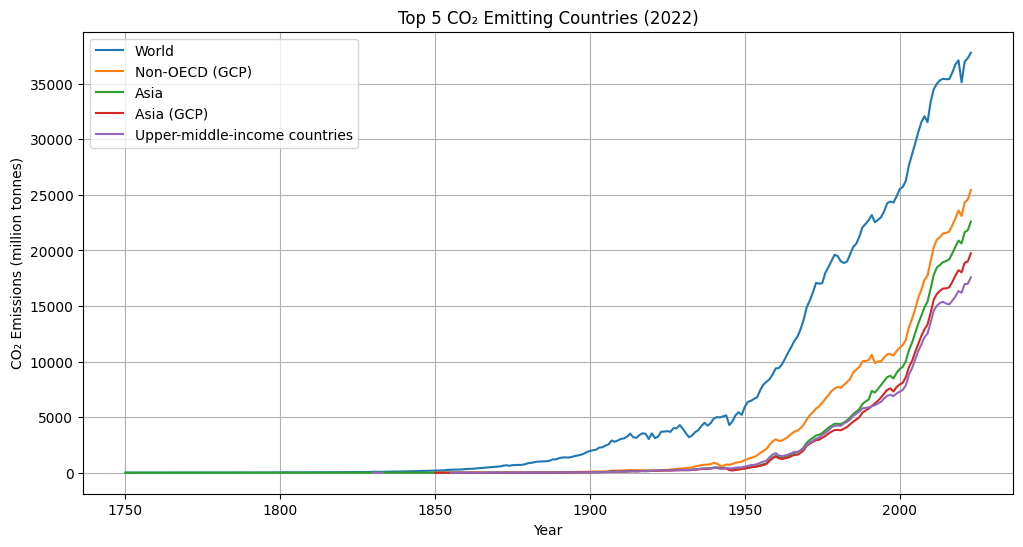

In [3]:
# Climate Change Analysis using PySpark (Hadoop ecosystem)
# This script requires a working Spark environment (e.g., Google Colab with PySpark, or a local Hadoop/Spark install).

# Install PySpark if not already installed (uncomment if needed)
# !pip install pyspark pandas matplotlib plotly --quiet

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import pearsonr

# Start Spark session
spark = SparkSession.builder.appName("ClimateChangeAnalysis").getOrCreate()

# Load temperature anomaly data
url_temp = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
temp_pd = pd.read_csv(url_temp, skiprows=1)
temp_pd = temp_pd.rename(columns={'Year': 'year', 'J-D': 'anomaly'})
temp_pd = temp_pd[['year', 'anomaly']].dropna()
temp_pd['year'] = temp_pd['year'].astype(int)
df_temp = spark.createDataFrame(temp_pd)

# Load CO₂ emission data
url_co2 = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'
co2_pd = pd.read_csv(url_co2)
co2_pd = co2_pd[co2_pd['country'] == 'World'][['year', 'co2']].dropna()
co2_pd['year'] = co2_pd['year'].astype(int)
df_co2 = spark.createDataFrame(co2_pd)

# Join datasets on year
df_joined = df_temp.join(df_co2, on='year', how='inner')

# Convert to Pandas for correlation and plotting
joined_pd = df_joined.toPandas()
anomaly = pd.to_numeric(joined_pd['anomaly'], errors='coerce')
co2 = pd.to_numeric(joined_pd['co2'], errors='coerce')
mask = anomaly.notna() & co2.notna()
anomaly = anomaly[mask]
co2 = co2[mask]

print("Length of anomaly:", len(anomaly))
print("Length of co2:", len(co2))

if len(anomaly) > 1 and len(co2) > 1:
    corr, p_value = pearsonr(anomaly, co2)
    print(f'Pearson correlation coefficient: {corr:.2f}')
    print(f'P-value: {p_value:.3g}')
else:
    print("Not enough data points to compute correlation. Please check your data.")

# Plot global temperature anomaly
plt.figure(figsize=(12,6))
plt.plot(joined_pd['year'], anomaly, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Temperature Anomaly (NASA GISTEMP)')
plt.grid(True)
plt.show()

# Plot global CO₂ emissions
plt.figure(figsize=(12,6))
plt.plot(joined_pd['year'], co2, marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (million tonnes)')
plt.title('Global CO₂ Emissions (Our World in Data)')
plt.grid(True)
plt.show()

# Interactive plot
fig = px.line(joined_pd, x='year', y='co2', title='Global CO₂ Emissions (Interactive)')
fig.show()

# Top 5 emitting countries in a recent year using Spark DataFrame
year = 2022
co2_countries_pd = pd.read_csv(url_co2)
top_countries = co2_countries_pd[co2_countries_pd['year'] == year].sort_values('co2', ascending=False).head(5)['country'].tolist()
df_top_pd = co2_countries_pd[co2_countries_pd['country'].isin(top_countries)]

plt.figure(figsize=(12,6))
for country in top_countries:
    plt.plot(df_top_pd[df_top_pd['country'] == country]['year'], df_top_pd[df_top_pd['country'] == country]['co2'], label=country)
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (million tonnes)')
plt.title(f'Top 5 CO₂ Emitting Countries ({year})')
plt.legend()
plt.grid(True)
plt.show()

# Choropleth map for CO₂ emissions by country (2022)
df_map = co2_countries_pd[co2_countries_pd['year'] == year]
fig = px.choropleth(
    df_map,
    locations="iso_code",
    color="co2",
    hover_name="country",
    color_continuous_scale="Reds",
    title=f"CO₂ Emissions by Country ({year})"
)
fig.show()

# Stop Spark session
spark.stop()